# Item-Based Collaborative Filtering - Movie Recommender System

## User-Based (Hard, users' appetite change over time) vs Item-Based (Items correlation don't change)

In [1]:
%%time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import pickle
%matplotlib inline

Wall time: 1.29 s


## STEP #1: IMPORT DATASET

In [2]:
movie_titles_df = pd.read_csv(filepath_or_buffer="Movie_Id_Titles")
movie_titles_df

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [3]:
movie_titles_df.isna().mean()

item_id    0.0
title      0.0
dtype: float64

In [4]:
movies_rating_df = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_rating_df = movies_rating_df.drop(columns=['timestamp'])
movies_rating_df

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
...,...,...,...
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2


In [5]:
movies_rating_df.isnull().mean()

user_id    0.0
item_id    0.0
rating     0.0
dtype: float64

In [6]:
movies_rating_df = pd.merge(left=movie_titles_df, right=movies_rating_df, how="inner", 
                            left_on="item_id", right_on="item_id")
movies_rating_df

,item_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3
...,...,...,...,...
99998,1678,Mat' i syn (1997),863,1
99999,1679,B. Monkey (1998),863,3
100000,1680,Sliding Doors (1998),863,2
100001,1681,You So Crazy (1994),896,3


In [7]:
movies_rating_df["title"].nunique()

1664

## STEP #2: VISUALIZE DATASET

In [8]:
%%time
movies_rating_df.groupby(by=["title"])["rating"].describe()

Wall time: 1.59 s


,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


In [9]:
%%time
movies_rating_df = movies_rating_df.groupby(by=["title"])["rating"].describe()[["count", "mean"]].reset_index()
movies_rating_df

Wall time: 1.52 s


,title,count,mean
0,'Til There Was You (1997),9.0,2.333333
1,1-900 (1994),5.0,2.600000
2,101 Dalmatians (1996),109.0,2.908257
3,12 Angry Men (1957),125.0,4.344000
4,187 (1997),41.0,3.024390
...,...,...,...
1659,Young Guns II (1990),44.0,2.772727
1660,"Young Poisoner's Handbook, The (1995)",41.0,3.341463
1661,Zeus and Roxanne (1997),6.0,2.166667
1662,unknown,9.0,3.444444


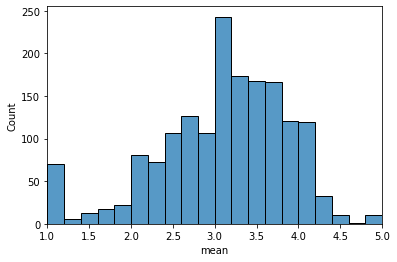

In [10]:
sns.histplot(data=movies_rating_df, x="mean", bins=20)
plt.xlim(1, 5);

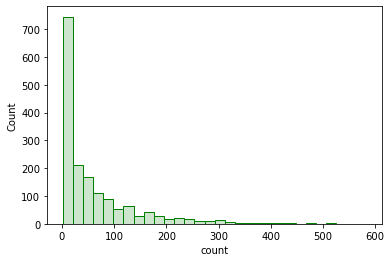

In [11]:
sns.histplot(data=movies_rating_df, x="count", color="green", alpha=0.2, edgecolor="green", bins=30);

In [12]:
# Let's see the highest rated movies!
# Apparently these movies does not have many reviews (i.e.: small number of ratings)
movies_rating_df[movies_rating_df['mean'] == 5]

,title,count,mean
30,Aiqing wansui (1994),1.0,5.0
462,Entertaining Angels: The Dorothy Day Story (1996),1.0,5.0
633,"Great Day in Harlem, A (1994)",1.0,5.0
944,Marlene Dietrich: Shadow and Light (1996),1.0,5.0
1172,Prefontaine (1997),3.0,5.0
1273,"Saint of Fort Washington, The (1993)",2.0,5.0
1277,Santa with Muscles (1996),2.0,5.0
1359,Someone Else's America (1995),1.0,5.0
1387,Star Kid (1997),3.0,5.0
1472,They Made Me a Criminal (1939),1.0,5.0


In [13]:
# List all the movies that are most rated
# Please note that they are not necessarily have the highest rating (mean)
movies_rating_df.sort_values(by=['count'], ascending=False).head(100)

,title,count,mean
1398,Star Wars (1977),584.0,4.359589
333,Contact (1997),509.0,3.803536
498,Fargo (1996),508.0,4.155512
1234,Return of the Jedi (1983),507.0,4.007890
860,Liar Liar (1997),485.0,3.156701
...,...,...,...
36,Aladdin (1992),219.0,3.812785
109,Babe (1995),219.0,3.995434
1588,Volcano (1997),219.0,2.808219
1507,To Kill a Mockingbird (1962),219.0,4.292237


### STEP #3: PERFORM ITEM-BASED COLLABORATIVE FILTERING ON ONE MOVIE SAMPLE

In [14]:
movie_titles_df = pd.read_csv(filepath_or_buffer="Movie_Id_Titles")
movies_rating_df = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_rating_df = movies_rating_df.drop(columns=['timestamp'])
movies_rating_df = pd.merge(left=movie_titles_df, right=movies_rating_df, how="inner", 
                            left_on="item_id", right_on="item_id")
movies_rating_df

,item_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3
...,...,...,...,...
99998,1678,Mat' i syn (1997),863,1
99999,1679,B. Monkey (1998),863,3
100000,1680,Sliding Doors (1998),863,2
100001,1681,You So Crazy (1994),896,3


In [15]:
userid_movietitle_matrix = movies_rating_df.pivot_table(values="rating", index="user_id", columns="title")
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
titanic = userid_movietitle_matrix['Titanic (1997)']
titanic

user_id
0      NaN
1      NaN
2      5.0
3      NaN
4      NaN
      ... 
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 944, dtype: float64

In [17]:
userid_movietitle_matrix.columns[userid_movietitle_matrix.columns.str.lower().str.contains("star war")]

Index(['Star Wars (1977)'], dtype='object', name='title')

In [18]:
userid_movietitle_matrix["Star Wars (1977)"]

user_id
0      5.0
1      5.0
2      5.0
3      NaN
4      5.0
      ... 
939    NaN
940    4.0
941    NaN
942    5.0
943    4.0
Name: Star Wars (1977), Length: 944, dtype: float64

In [19]:
# # Let's calculate the correlations
titanic_correlations = pd.DataFrame(data=userid_movietitle_matrix.corrwith(other=titanic), columns=['Correlation'])
titanic_correlations

,Correlation
title,
'Til There Was You (1997),-0.062017
1-900 (1994),NaN
101 Dalmatians (1996),0.120113
12 Angry Men (1957),0.077700
187 (1997),0.315654
...,...
Young Guns II (1990),0.317274
"Young Poisoner's Handbook, The (1995)",0.356783
Zeus and Roxanne (1997),NaN


In [20]:
ratings_df_count = movies_rating_df.groupby(by=["title"])["rating"].count()
ratings_df_count = ratings_df_count.to_frame()
ratings_df_count = ratings_df_count.rename(mapper={"rating": "count"}, axis=1)
ratings_df_count

,count
title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41
...,...
Young Guns II (1990),44
"Young Poisoner's Handbook, The (1995)",41
Zeus and Roxanne (1997),6


In [21]:
titanic_correlations = titanic_correlations.join(other=ratings_df_count)
titanic_correlations = titanic_correlations.dropna()
titanic_correlations = titanic_correlations[titanic_correlations["count"]>80].sort_values(by=["Correlation"], 
                                                                                          ascending=False)
titanic_correlations

,Correlation,count
title,,
Titanic (1997),1.000000,350
"River Wild, The (1994)",0.497600,146
"Abyss, The (1989)",0.472103,151
Bram Stoker's Dracula (1992),0.443560,120
True Lies (1994),0.435104,208
...,...,...
Brazil (1985),-0.243532,208
Richard III (1995),-0.275451,89
Cold Comfort Farm (1995),-0.307150,125


## STEP#4: CREATE AN ITEM-BASED COLLABORATIVE FILTER ON THE ENTIRE DATASET 

In [22]:
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# pearson : standard correlation coefficient
# Obtain the correlations between all movies in the dataframe

movie_correlations = userid_movietitle_matrix.corr(method = 'pearson', min_periods = 80)
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.178848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
myRatings = pd.read_csv("My_Ratings.csv")
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [25]:
myRatings["Movie Name"][0]

'Liar Liar (1997)'

In [26]:
similar_movies_list = pd.Series()

for i in range(2):
    similar_movie = movie_correlations[ myRatings["Movie Name"][i] ].dropna() # Get same movies with same ratings
    similar_movie = similar_movie.map(lambda x: x * myRatings['Ratings'][i]) # Scale the similarity by your given ratings
    similar_movies_list = similar_movies_list.append(similar_movie)

In [27]:
similar_movies_list.sort_values(ascending=False)

Liar Liar (1997)                                                               5.000000
Con Air (1997)                                                                 2.349141
Pretty Woman (1990)                                                            2.348951
Michael (1996)                                                                 2.210110
Indiana Jones and the Last Crusade (1989)                                      2.072136
                                                                                 ...   
Leaving Las Vegas (1995)                                                      -0.686991
Fantasia (1940)                                                               -0.739094
This Is Spinal Tap (1984)                                                     -0.791064
Brazil (1985)                                                                 -0.806306
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)   -1.190462
Length: 574, dtype: float64